## K-Means Clustering

**Overview**<br>
<a href="https://archive.ics.uci.edu/ml/datasets/online+retail">Online retail is a transnational data set</a> which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

The steps are broadly:
1. Read and understand the data
2. Clean the data
3. Prepare the data for modelling
4. Modelling
5. Final analysis and reco

In [2]:
# CHECK THE HYPERLINK

In [3]:
# WE WANTO TO DO CUSTOMER SEGMENTATION FOR THIS DATA SET

# 1. Read and visualise the data

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import datetime as dt

In [6]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [7]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [8]:
# read the dataset
df = pd.read_csv("Online+Retail.csv",sep=",", encoding="ISO-8859-1", header=0)

In [9]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [10]:
#Invoice number is same for first 4 raws
# but stock id is diff
#customer_id same
# means that the same customer has ordered multiple stocks in one purchase

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [12]:
df.shape

(541909, 8)

# 2. Clean the data

In [13]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [14]:
round(100*(df.isnull().sum())/df.shape[0] ,2)

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [15]:
# we can't drop customer id as it is important for our analysis
# so let's just remove the rows with missing values

In [16]:
# drop all rows having missing values
df.dropna(inplace=True)

In [17]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [18]:
df.shape

(406829, 8)

In [19]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [20]:
# new column: amount 
df['amount'] = df.Quantity*df.UnitPrice

In [21]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


# 3. Prepare the data for modelling

- R (Recency): Number of days since last purchase
- F (Frequency): Number of tracsactions
- M (Monetary): Total amount of transactions (revenue contributed)

In [22]:
# monetary
df_mon = df.groupby('CustomerID').amount.sum()
df_mon = df_mon.reset_index()
df_mon

,CustomerID,amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40
...,...,...
4367,18280.0,180.60
4368,18281.0,80.82
4369,18282.0,176.60
4370,18283.0,2094.88


In [23]:
# frequency
freq = df.groupby('CustomerID').InvoiceNo.count()
freq = freq.reset_index()
freq.columns = ['CustomerID','Frequency']
freq.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [24]:
# merge the two dfs
df2 = pd.merge(df_mon,freq,on = 'CustomerID',how = 'inner')
df2.head()

,CustomerID,amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [25]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


In [26]:
# recency
# convert to datetime
df.InvoiceDate = pd.to_datetime(df.InvoiceDate,format = '%d-%m-%Y %H:%M') #capital y,check other formats
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


# check
https://www.datacamp.com/tutorial/converting-strings-datetime-objects#recap

In [27]:
# compute the max date
max_date = max(df.InvoiceDate)
max_date

Timestamp('2011-12-09 12:50:00')

In [28]:
# compute the diff
df['diff'] = max_date - df.InvoiceDate
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [29]:
# recency
last_purchase = df.groupby('CustomerID')['diff'].min()
last_purchase = last_purchase.reset_index()
last_purchase.head()

,CustomerID,diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [30]:
# merge
df3 = pd.merge(df2,last_purchase,on ='CustomerID',how = 'inner')
df3.columns = ['CustomerID', 'amount', 'frequency', 'recency']
df3.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325 days 02:33:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00
3,12349.0,1757.55,73,18 days 02:59:00
4,12350.0,334.40,17,309 days 20:49:00


In [31]:
# number of days only
df3.recency = df3.recency.dt.days
df3.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


C:\Users\aksha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


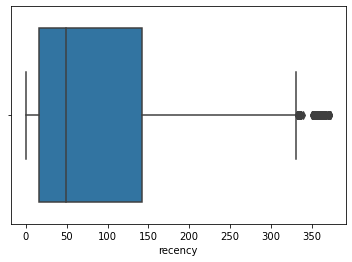

In [32]:
# 1. outlier treatment
sns.boxplot(df3.recency)
plt.show()

In [33]:
# two types of outliers:
# - statistical
# - domain specific

In [34]:
df3.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


In [35]:
df3.shape

(4372, 4)

In [36]:
# removing (statistical) outliers  (amount)            #doing this because when we plotted below, we could s33 outliers
Q1 = df3.amount.quantile(0.05)
Q3 = df3.amount.quantile(0.95)
IQR = Q3 - Q1

In [37]:
df3 = df3[(df3.amount>= Q1 - 1.5*IQR)&(df3.amount<= Q3+1.5*IQR)]

In [38]:
df3.shape

(4313, 4)

In [39]:
df3.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


In [40]:
# outlier treatment for recency
Q1 = df3.recency.quantile(0.05)
Q3 = df3.recency.quantile(0.95)
IQR = Q3 - Q1
df3 = df3[(df3.recency>= Q1 - 1.5*IQR)&(df3.recency<= Q3+1.5*IQR)]

In [41]:
df3.shape

(4313, 4)

In [42]:
# outlier treatment for frequency
Q1 = df3.frequency.quantile(0.05)
Q3 = df3.frequency.quantile(0.95)
IQR = Q3 - Q1
df3 = df3[(df3.frequency>= Q1 - 1.5*IQR)&(df3.frequency<= Q3+1.5*IQR)]

In [43]:
df3.shape

(4293, 4)

In [45]:
df3.to_csv('df3.csv')

In [43]:
# 2. rescaling
rfm_df = df3[['amount','frequency','recency']]

#instantiate
scaler = StandardScaler()

# fit_transform
rfm_df = scaler.fit_transform(rfm_df)
rfm_df.shape


(4293, 3)

In [44]:
rfm_df = pd.DataFrame(rfm_df)
rfm_df.columns = ['amount', 'frequency', 'recency']
rfm_df.head()

,amount,frequency,recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


# Hopkins Statistics:

The Hopkins statistic, is a statistic which gives a value which indicates the cluster tendency, in other words: how well the data can be clustered.

    If the value is between {0.01, ...,0.3}, the data is regularly spaced.

    If the value is around 0.5, it is random.

    If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster.



Some usefull links to understand Hopkins Statistics:
- [WikiPedia](https://en.wikipedia.org/wiki/Hopkins_statistic)
- [Article](http://www.sthda.com/english/articles/29-cluster-validation-essentials/95-assessing-clustering-tendency-essentials/)

In [54]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

Notes regarding Hopkins Statistic

    You don't need to know how the algorithm of  Hopkins Statistic works. The algorithm is pretty advanced and hence you don't need to know its workings but rather only interpret the value that it assigns to the dataframe.
    On multiple iterations of Hopkins Statistic, you would be getting multiple values since the algorithm uses some randomisation in the initialisation part of the code. Therefore it is advised to run it a couple of times before confirming whether the data is suitable for clustering or not.

In [46]:
#Use the Hopkins Statistic function by passing the above dataframe as a paramter
hopkins(rfm_df)

0.9570910259876909

In [47]:
hopkins(rfm_df)

0.9557158163294829

In [48]:
hopkins(rfm_df)

0.9575981796224147

# 4. Modelling

In [49]:
# k-means with some arbitrary k
kmeans = KMeans(n_clusters= 4, max_iter=50)

In [50]:
# k-means with some arbitrary k
kmeans = KMeans(n_clusters= 4, max_iter=50) #instantiating an object

In [51]:
#if the algorithm doesn't converge in 50 iterations, then whatever clusters are formed at the end of 50 iterations 
# will be return

In [52]:
kmeans.fit(rfm_df) 

KMeans(max_iter=50, n_clusters=4)

In [53]:
kmeans.labels_  #labels of all the data points

array([2, 3, 0, ..., 2, 0, 0])

In [54]:
len(kmeans.labels_)

4293

## Finding the Optimal Number of Clusters

### SSD

Now you might be thinking why the number of clusters is taken as 4 and not any other number. To find the optimum number of clusters, we use two techniques - the elbow curve method and the silhouette score method. 

#### elbow-curve/SSD (sum of squared distances)
- you start with multiple clusters (k=2,k=3,k=4 etc)
- Then you check the amount/percentage of information present in each cluster size
- At any point when the adding anymore clusters doesn't seem to beneficial then you stop there.


In [55]:
help(KMeans)

Help on class KMeans in module sklearn.cluster._kmeans:

class KMeans(sklearn.base.TransformerMixin, sklearn.base.ClusterMixin, sklearn.base.BaseEstimator)
 |  KMeans(n_clusters=8, *, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='deprecated', verbose=0, random_state=None, copy_x=True, n_jobs='deprecated', algorithm='auto')
 |  
 |  K-Means clustering.
 |  
 |  Read more in the :ref:`User Guide <k_means>`.
 |  
 |  Parameters
 |  ----------
 |  
 |  n_clusters : int, default=8
 |      The number of clusters to form as well as the number of
 |      centroids to generate.
 |  
 |  init : {'k-means++', 'random'}, callable or array-like of shape             (n_clusters, n_features), default='k-means++'
 |      Method for initialization:
 |  
 |      'k-means++' : selects initial cluster centers for k-mean
 |      clustering in a smart way to speed up convergence. See section
 |      Notes in k_init for more details.
 |  
 |      'random': choose `n_clusters` o

FROM ABOVE HELP<BR>
 inertia_ : float
 |      Sum of squared distances of samples to their closest cluster center

In [56]:
ssd = []
range_n_clusters = [2,3,4,5,6,7,8] #define the range of clusters we want to experiment with.
                                    # anything more than 8 doesn't look very useful at the customer segmentation view.
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters , max_iter=50)
    kmeans.fit(rfm_df) 
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd

In [57]:
ssd  # a list containg Sum of squared distances of samples to their closest cluster 
#center for each 7 cluster sizes 

[7661.7058693207655,
 4433.580619302109,
 3360.5241854981464,
 2802.8241284834658,
 2391.9961815792594,
 2039.2745592166307,
 1825.735802595515]

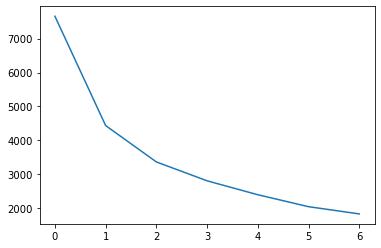

In [58]:
plt.plot(ssd) #x axis -list index

In [59]:
# after 2nd index - 4 clusters to 5 clusters
# the value of ssd doesn't decrease significantly , not so steeply?
# after first index, first elbiw
# so having 3 clusters is good, beyond that the change is less


In [60]:
#imaging datapoints with a centroid - will have huge value of ssd
# now thing of two clusters having a centroid in each, the ssd will be less
# when you keep on increase the value of ssd will decrease

#### Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [61]:
# for example
# data point num 10 (cluster 1)
# p - 100
#q - 10
# score = 90/100 =0.9
# good score
# good clustering
# so you caaculate the silhouette score for entire data points then take the avaerage of those score for each 
# clustering

In [62]:
range_n_clusters = [2,3,4,5,6,7,8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters = num_clusters,max_iter=50)
    kmeans.fit(rfm_df)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df,cluster_labels)
    print("for n_clusters = {0}, the silhouette score is {1}".format(num_clusters,silhouette_avg))

for n_clusters = 2, the silhouette score is 0.5415858652525395
for n_clusters = 3, the silhouette score is 0.5084896296141937
for n_clusters = 4, the silhouette score is 0.4816531272445321
for n_clusters = 5, the silhouette score is 0.4645801831125689
for n_clusters = 6, the silhouette score is 0.4170584389874765
for n_clusters = 7, the silhouette score is 0.4158653100759283
for n_clusters = 8, the silhouette score is 0.3853510820155986


- silhouette score of cluster 2 is high -  mathematically optimal
- from bussiness point of view it may not be that interpretable??
- use a cluster number by combing the result of these two analysis and your based on your bussiness goal
- if 3 clusters is more natural to your marketing team,then go ahead with 3



In [63]:
# final model with k=3
kmeans = KMeans(n_clusters=3,max_iter=50)
kmeans.fit(rfm_df)

KMeans(max_iter=50, n_clusters=3)

In [64]:
kmeans.labels_

array([2, 1, 0, ..., 2, 0, 0])

In [65]:
# assign the label
df3['cluster_id']  = kmeans.labels_

In [66]:
df3.head()

,CustomerID,amount,frequency,recency,cluster_id
0,12346.0,0.00,2,325,2
1,12347.0,4310.00,182,1,1
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,2


C:\Users\aksha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='cluster_id', ylabel='amount'>

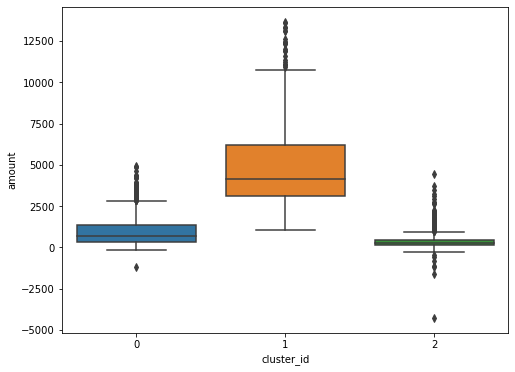

In [67]:
#plot
plt.figure(figsize = [8,6])
sns.boxplot(df3.cluster_id,df3.amount)

In [ ]:
#clster 1 represents the customers with higher price value

C:\Users\aksha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


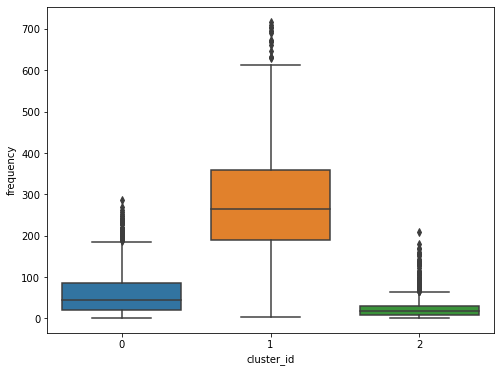

In [69]:
plt.figure(figsize = [8,6])
sns.boxplot(df3.cluster_id,df3.frequency)
plt.show()

In [ ]:
#cluster one is more frequent buyers

C:\Users\aksha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='cluster_id', ylabel='recency'>

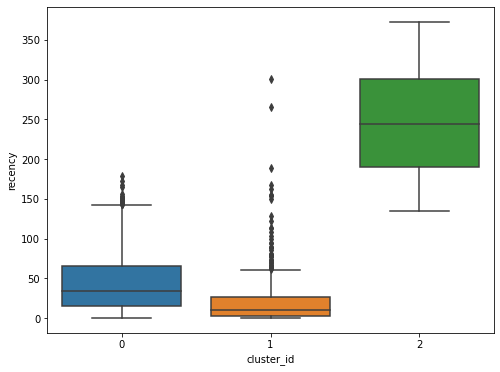

In [70]:
plt.figure(figsize = [8,6])
sns.boxplot(df3.cluster_id,df3.recency)

In [ ]:
# clusters 1 is more recent customers

# Let's Have Some Fun

In [3]:
dff = pd.read_excel('Main.xlsx')

In [4]:
dff.head()

,Area Name,Illiterate,Graduate & above,Total - Population,Percentage Illiterate,Percentage Graduate & above
0,State - JAMMU & KASHMIR,3378518,385463,12541302,26.939133,3.073549
1,State - HIMACHAL PRADESH,963742,267936,6864602,14.039299,3.903154
2,State - PUNJAB,4886265,979525,27743338,17.612390,3.530667
3,State - CHANDIGARH,175200,91276,1055450,16.599555,8.648065
4,State - UTTARAKHAND,1929236,525301,10086292,19.127307,5.208069


In [8]:
dff.shape

(35, 6)

In [9]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Area Name                    35 non-null     object 
 1   Illiterate                   35 non-null     int64  
 2   Graduate & above             35 non-null     int64  
 3   Total - Population           35 non-null     int64  
 4   Percentage Illiterate        35 non-null     float64
 5   Percentage Graduate & above  35 non-null     float64
dtypes: float64(2), int64(3), object(1)
memory usage: 1.8+ KB


In [10]:
dff.columns

Index(['Area Name', 'Illiterate', 'Graduate & above', 'Total - Population',
       'Percentage Illiterate', 'Percentage Graduate & above'],
      dtype='object')

<AxesSubplot:>

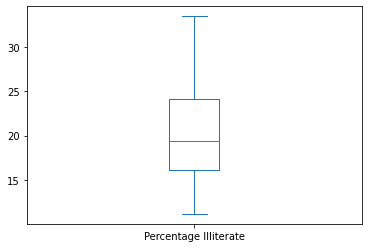

In [14]:
dff['Percentage Illiterate'].plot.box()

In [15]:
#rescaling
ndf = dff[['Percentage Illiterate','Percentage Graduate & above']]


In [16]:
scaler = StandardScaler()
ndf = scaler.fit_transform(ndf)

In [21]:
ndf = pd.DataFrame(ndf)
ndf.columns = ['Percentage Illiterate','Percentage Graduate & above']
ndf.head()

,Percentage Illiterate,Percentage Graduate & above
0,1.203902,-0.250185
1,-1.067532,0.256526
2,-0.438373,0.029016
3,-0.616716,3.154645
4,-0.171623,1.053547


In [23]:
hopkins(ndf)

0.7370942523220797

In [24]:
kmeans = KMeans(n_clusters=4,max_iter=50)

In [25]:
kmeans.fit(ndf)

KMeans(max_iter=50, n_clusters=4)

In [26]:
kmeans.labels_

array([1, 3, 3, 0, 3, 3, 0, 1, 1, 1, 3, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2,
       1, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 0, 3])

In [27]:
ssd = []
range_n_clusters = [2,3,4,5,6,7,8] #define the range of clusters we want to experiment with.
                                    # anything more than 8 doesn't look very useful at the customer segmentation view.
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters , max_iter=50)
    kmeans.fit(ndf) 
    ssd.append(kmeans.inertia_)

In [28]:
ssd

[34.12639370035005,
 18.36506002097687,
 12.554775415576582,
 9.687753027637363,
 7.775489966508538,
 6.377354527924627,
 5.407439779980732]

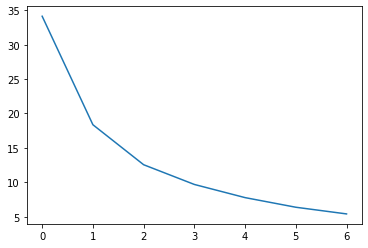

In [30]:
plt.plot(ssd)

In [31]:
kmeans = KMeans(n_clusters=2,max_iter=50)
kmeans.fit(ndf)

KMeans(max_iter=50, n_clusters=2)

In [32]:
kmeans.labels_

array([1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [33]:
ndf['cluster_id'] = kmeans.labels_

C:\Users\aksha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='cluster_id', ylabel='Percentage Illiterate'>

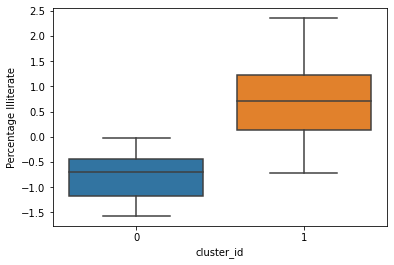

In [34]:
sns.boxplot(ndf.cluster_id,ndf['Percentage Illiterate'])

C:\Users\aksha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='cluster_id', ylabel='Percentage Graduate & above'>

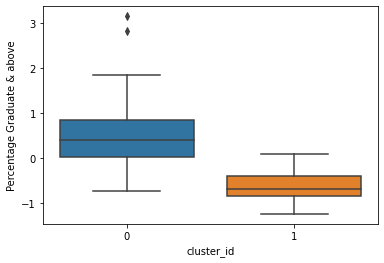

In [35]:
sns.boxplot(ndf.cluster_id,ndf['Percentage Graduate & above'])

You looked at RPI segmentation, which looks at what kind of relationship you have had with the person before, what type of person he/she is, and the intent of the person at the time of buying.

 

You also looked at the CDJ segmentation, which looks at the path that customers take while experiencing your product.

 

Now, let us turn our attention to another clustering technique — hierarchical clustering — in the next session.

In [40]:
#graded assi

In [74]:
df = pd.read_csv('Cricket.csv', encoding="ISO-8859-1")

In [75]:
df.head()

,Player,Span,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0
0,SR Tendulkar (INDIA),1989-2012,463,452,41,18426,200*,44.83,21367,86.23,49,96,20
1,KC Sangakkara (Asia/ICC/SL),2000-2015,404,380,41,14234,169,41.98,18048,78.86,25,93,15
2,RT Ponting (AUS/ICC),1995-2012,375,365,39,13704,164,42.03,17046,80.39,30,82,20
3,ST Jayasuriya (Asia/SL),1989-2011,445,433,18,13430,189,32.36,14725,91.20,28,68,34
4,DPMD Jayawardene (Asia/SL),1998-2015,448,418,39,12650,144,33.37,16020,78.96,19,77,28


In [76]:
df.shape

(79, 13)

In [77]:
dff = df[['SR','Ave']]

In [78]:
scaler = StandardScaler()

In [79]:
dff = scaler.fit_transform(dff)

In [80]:
dff = pd.DataFrame(dff)
dff.columns = ['SR','Ave']
dff.head()

,SR,Ave
0,0.703152,1.072294
1,-0.044139,0.587725
2,0.110997,0.596226
3,1.207091,-1.047909
4,-0.034000,-0.876185


In [81]:
hopkins(dff)

0.6958968963249563

In [82]:
kmeans = KMeans(n_clusters=4,max_iter=50,random_state=100)

In [83]:
kmeans.fit(dff)

KMeans(max_iter=50, n_clusters=4, random_state=100)

In [84]:
kmeans.labels_

array([3, 1, 1, 0, 2, 1, 1, 1, 1, 1, 0, 1, 0, 3, 2, 3, 2, 0, 1, 1, 0, 1,
       2, 1, 0, 3, 2, 0, 2, 1, 2, 2, 1, 2, 3, 2, 2, 1, 3, 1, 2, 2, 3, 2,
       2, 2, 1, 2, 2, 1, 0, 1, 2, 2, 2, 2, 1, 0, 2, 0, 2, 0, 1, 3, 3, 1,
       1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 2, 0, 2])

In [85]:
ha = df[['Player','SR','Ave']]

In [86]:
ha['cluster_id'] = kmeans.labels_

C:\Users\aksha\AppData\Local\Temp/ipykernel_664/3843221570.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ha['cluster_id'] = kmeans.labels_


In [87]:
ha

,Player,SR,Ave,cluster_id
0,SR Tendulkar (INDIA),86.23,44.83,3
1,KC Sangakkara (Asia/ICC/SL),78.86,41.98,1
2,RT Ponting (AUS/ICC),80.39,42.03,1
3,ST Jayasuriya (Asia/SL),91.20,32.36,0
4,DPMD Jayawardene (Asia/SL),78.96,33.37,2
...,...,...,...,...
74,CG Greenidge (WI),64.92,45.03,1
75,Misbah-ul-Haq (PAK),73.75,43.40,1
76,PD Collingwood (ENG),76.98,35.36,2
77,A Symonds (AUS),92.44,39.75,0


In [106]:
pd.set_option('display.max_rows', 500)

In [107]:
ha

,Player,SR,Ave,cluster_id
0,SR Tendulkar (INDIA),86.23,44.83,3
1,KC Sangakkara (Asia/ICC/SL),78.86,41.98,1
2,RT Ponting (AUS/ICC),80.39,42.03,1
3,ST Jayasuriya (Asia/SL),91.20,32.36,0
4,DPMD Jayawardene (Asia/SL),78.96,33.37,2
5,Inzamam-ul-Haq (Asia/PAK),74.24,39.52,1
6,JH Kallis (Afr/ICC/SA),72.89,44.36,1
7,SC Ganguly (Asia/INDIA),73.70,41.02,1
8,R Dravid (Asia/ICC/INDIA),71.24,39.16,1
9,BC Lara (ICC/WI),79.51,40.48,1


C:\Users\aksha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='cluster_id', ylabel='SR'>

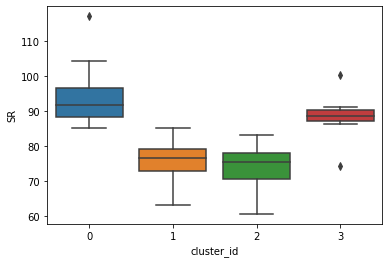

In [108]:
sns.boxplot(ha.cluster_id,ha.SR)

C:\Users\aksha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='cluster_id', ylabel='Ave'>

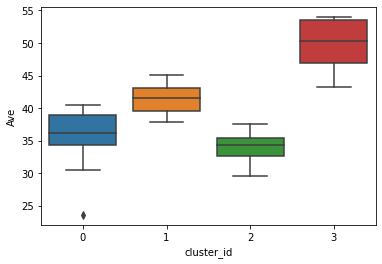

In [109]:
sns.boxplot(ha.cluster_id,ha.Ave)

In [59]:
ssd = []
range_n_clusters = [2,3,4,5,6,7,8] #define the range of clusters we want to experiment with.
                                    # anything more than 8 doesn't look very useful at the customer segmentation view.
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters , max_iter=50)
    kmeans.fit(ndf) 
    ssd.append(kmeans.inertia_)

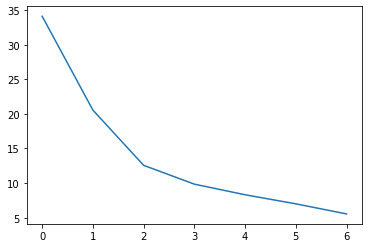

In [60]:
plt.plot(ssd)

In [66]:
kmeans = KMeans(n_clusters=2,max_iter=50,random_state=100)
kmeans.fit(dff)
kmeans.labels_

array([1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0])

In [67]:
dff['cluster_id'] = kmeans.labels_

C:\Users\aksha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='cluster_id', ylabel='SR'>

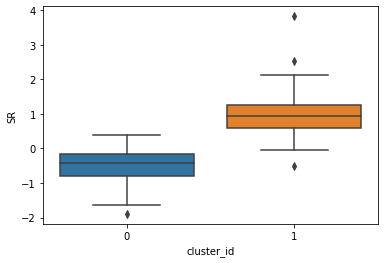

In [68]:
sns.boxplot(dff.cluster_id,dff.SR)

C:\Users\aksha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='cluster_id', ylabel='Ave'>

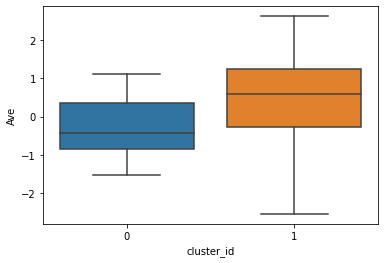

In [69]:
sns.boxplot(dff.cluster_id,dff.Ave)

In [70]:
KMeans?